In [1]:
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
from sqlalchemy import MetaData, Table
from sqlalchemy import select
import pandas as pd
import numpy as np
import collections


DB_USER = 'postgres'
DB_PASSWORD = 'pass123'
DB_HOST = 'localhost'
DB_PORT = 5432
DB_NAME = 'izpo-fifa'

DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
        
# https://docs.sqlalchemy.org/en/20/core/reflection.html
engine = create_engine(DATABASE_URL)
metadata_obj = MetaData()
metadata_obj.reflect(bind=engine)

In [2]:
# Load the tables
Player = Table("Player", metadata_obj, autoload_with=engine)
Attempt = Table("Attempt", metadata_obj, autoload_with=engine)
Foul = Table("Foul", metadata_obj, autoload_with=engine)
Game = Table("Game", metadata_obj, autoload_with=engine)
Gameday = Table("Gameday", metadata_obj, autoload_with=engine)
Player = Table("Player", metadata_obj, autoload_with=engine)
Team = Table("Team", metadata_obj, autoload_with=engine)
GamedayToPlayer = Table("_GamedayToPlayer", metadata_obj, autoload_with=engine)
PlayerToTeam = Table("_PlayerToTeam", metadata_obj, autoload_with=engine)


In [3]:
# Functions for fetching from database
def get_players_in_team_df():
    stmt = select(PlayerToTeam)
    with engine.connect() as conn:
        result = conn.execute(stmt)
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        return df.rename(columns={'A':'playerId','B':'teamId'})
def get_players_df():
    stmt = select(Player)
    with engine.connect() as conn:
        result = conn.execute(stmt)
        return pd.DataFrame(result.fetchall(), columns=result.keys())
def get_attempts_df():
    stmt = select(Attempt)
    with engine.connect() as conn:
        result = conn.execute(stmt)
        return pd.DataFrame(result.fetchall(), columns=result.keys())
def get_games_df():
    stmt = select(Game)
    with engine.connect() as conn:
        result = conn.execute(stmt)
        return pd.DataFrame(result.fetchall(), columns=result.keys())
def get_teams_df():
    stmt = select(Team)
    with engine.connect() as conn:
        result = conn.execute(stmt)
        return pd.DataFrame(result.fetchall(), columns=result.keys())



In [4]:
# Build up a statement
stmt = select(Player).where(Player.c.name == "Luka")
print(stmt)

SELECT "Player".id, "Player".name, "Player"."imageUri" 
FROM "Player" 
WHERE "Player".name = :name_1


In [5]:
# We use the following snippet to run the statements
with engine.connect() as conn:
    for row in conn.execute(stmt):
        print(row)

(1, 'Luka', 'https://izpo-fifa.s3.eu-central-1.amazonaws.com/XAVnOrxU1fRA0M5e2-cNT.png')


In [6]:
# Get all the players
stmt = select(Player.c.name, Player.c.id)
with engine.connect() as conn:
    for row in conn.execute(stmt):
        print(row)

('Gregor', 3)
('Žiga', 4)
('Jan', 5)
('Luka', 1)
('Kevin', 6)
('Rok', 7)
('Domen', 2)


In [7]:
# Get all attempts by user with id=11
stmt = select(Attempt).where(Attempt.c.shooterId == 11).limit(5)
with engine.connect() as conn:
    for row in conn.execute(stmt):
        print(row)


# Using Pandas

In [8]:
stmt = select(Attempt).where(Attempt.c.shooterId == 11)
with engine.connect() as conn:
    result = conn.execute(stmt)
    df = pd.DataFrame(result.fetchall(), columns=result.keys())

print(df.head())

Empty DataFrame
Columns: [id, time, distance, x, y, goal, autogoal, penalty, onTarget, shooterId, gameId, assistedId, goalieId]
Index: []


In [9]:
# Create a select statement to get the number of goals scored by each player
# This select returns all the attempts that resulted in a goal
stmt = (
    select(Player.c.id, Player.c.name, Attempt.c.shooterId, Attempt.c.goal)
    .select_from(Player.join(Attempt, Player.c.id == Attempt.c.shooterId))
    .where(Attempt.c.goal == True)
)

# Execute the statement and fetch the rows into a pandas DataFrame
with engine.connect() as conn:
    result = conn.execute(stmt)
    df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Group the data by player and count the number of goals
goals_by_player = df.groupby(["id", "name"]).size().reset_index(name="goals")
print(goals_by_player)

   id    name  goals
0   1    Luka      7
1   2   Domen      3
2   3  Gregor      8
3   4    Žiga     15
4   5     Jan      2
5   6   Kevin      1
6   7     Rok     15


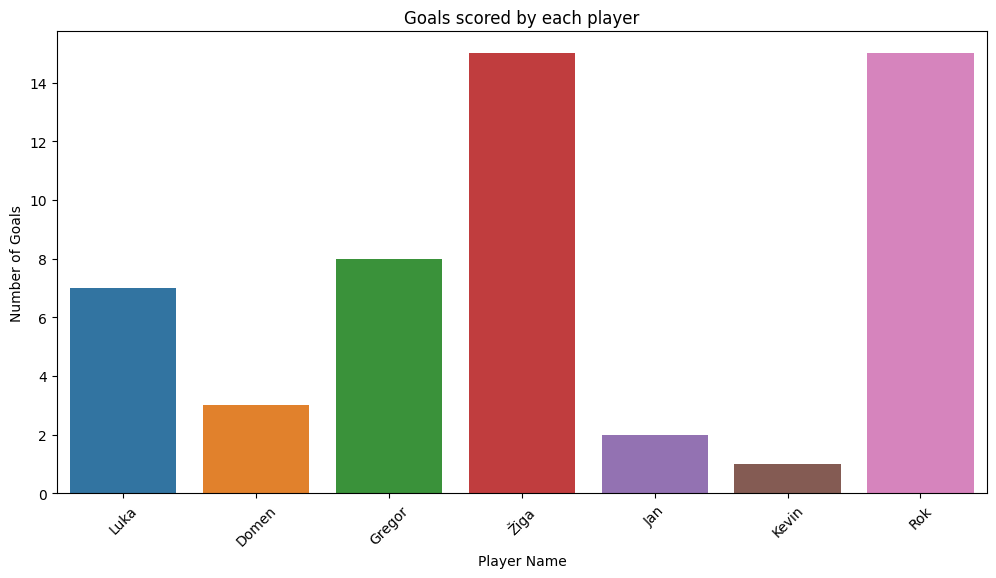

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='goals', data=goals_by_player)

# Set plot labels and title
plt.xlabel('Player Name')
plt.ylabel('Number of Goals')
plt.title('Goals scored by each player')

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Show the plot
plt.show()


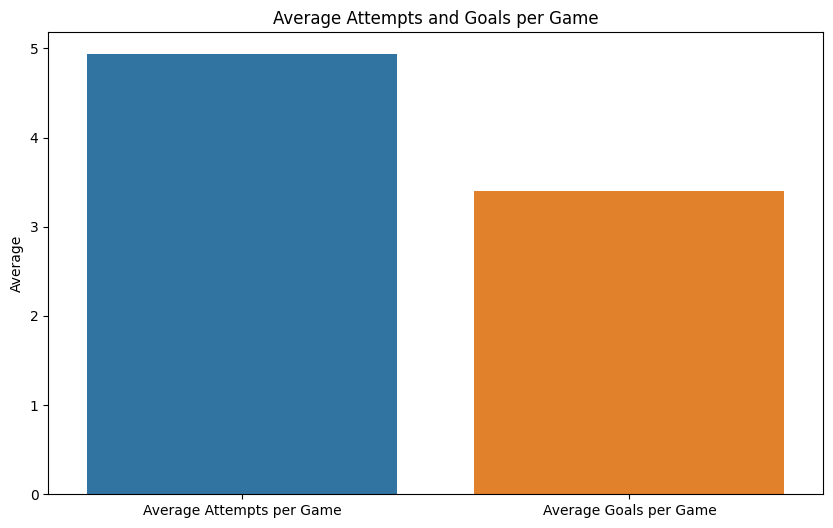

In [11]:
# How many attempts per game average
stmt = select(Attempt.c.id, Attempt.c.gameId, Attempt.c.goal)
with engine.connect() as conn:
    result = conn.execute(stmt)
    df_attempts = pd.DataFrame(result.fetchall(), columns=result.keys())

# Calculate attempts and goals per game
attempts_per_game = df_attempts.groupby("gameId").size().reset_index(name="attempts")
goals_per_game = df_attempts[df_attempts["goal"]].groupby("gameId").size().reset_index(name="goals")

# Calculate average attempts and goals per game
avg_attempts_per_game = attempts_per_game["attempts"].mean()
avg_goals_per_game = goals_per_game["goals"].mean()

# Create a DataFrame for the average values
avg_data = pd.DataFrame(
    {
        "metric": ["Average Attempts per Game", "Average Goals per Game"],
        "value": [avg_attempts_per_game, avg_goals_per_game],
    }
)

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x="metric", y="value", data=avg_data)

# Set plot labels and title
plt.xlabel("")
plt.ylabel("Average")
plt.title("Average Attempts and Goals per Game")

# Show the plot
plt.show()


## Distribution of attempts and goals by time

Right now we get only the attempts which have a time set. If the time is null we don't retrieve them. Alternatively we could and preprocess the data, interpolating the missing values.

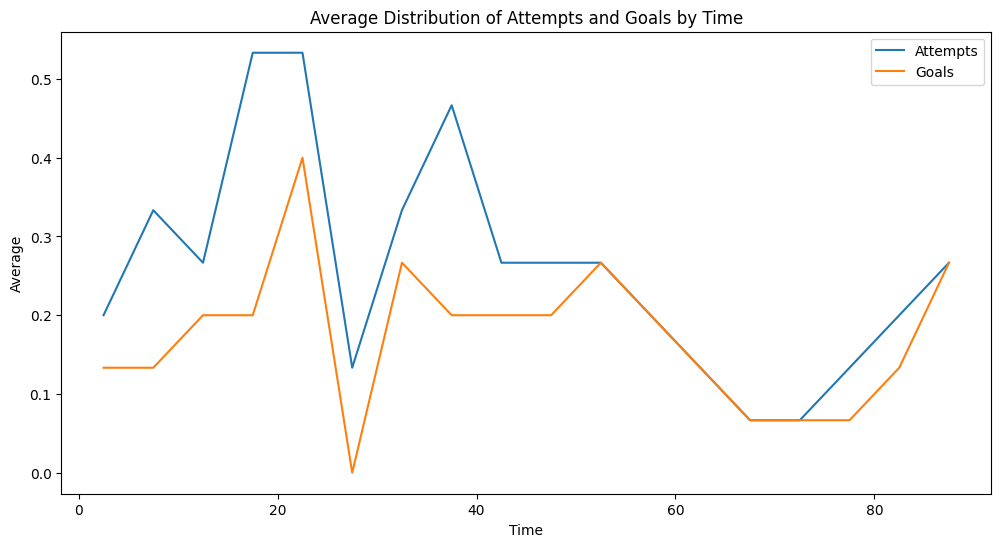

In [12]:
stmt = (
    select(Attempt.c.id, Attempt.c.gameId, Attempt.c.goal, Attempt.c.time)
    .where(Attempt.c.time != None)
)
with engine.connect() as conn:
    result = conn.execute(stmt)
    df_attempts = pd.DataFrame(result.fetchall(), columns=result.keys())

df_attempts['time_bin'] = pd.cut(df_attempts['time'], bins=np.arange(0, df_attempts['time'].max() + 1, 5))

# Group the attempts by the `time` column and count the number of attempts and goals
attempts_by_time = df_attempts.groupby("time_bin").size().reset_index(name="attempts")
goals_by_time = df_attempts[df_attempts["goal"]].groupby("time_bin").size().reset_index(name="goals")

# Merge the dataframes on the `time` column
time_data = pd.merge(attempts_by_time, goals_by_time, on="time_bin")

# Calculate the average number of attempts and goals for each time bucket
total_games = df_attempts["gameId"].nunique()
time_data["avg_attempts"] = time_data["attempts"] / total_games
time_data["avg_goals"] = time_data["goals"] / total_games
time_data['bin_mid'] = time_data['time_bin'].apply(lambda x: x.mid)

# Create a line chart with two lines, one for attempts and one for goals
plt.figure(figsize=(12, 6))
sns.lineplot(x="bin_mid", y="avg_attempts", data=time_data, label="Attempts")
sns.lineplot(x="bin_mid", y="avg_goals", data=time_data, label="Goals")

# Set plot labels and title
plt.xlabel("Time")
plt.ylabel("Average")
plt.title("Average Distribution of Attempts and Goals by Time")

# Show the legend
plt.legend()

# Show the plot
plt.show()


## Top 3 red carded players

In [13]:
stmt = select(Foul).where(Foul.c.card == 'red')
with engine.connect() as conn:
    result = conn.execute(stmt)
    red_fouls_df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Group the data by playerId and count the number of red cards
red_cards = red_fouls_df.groupby('playerId').size().reset_index(name='count')

# Sort the data by the count of red cards in descending order and select the top 3 players
top_players = red_cards.sort_values('count', ascending=False).head(3)[['playerId', 'count']]

print(top_players)



   playerId  count
1         2      3
0         1      1
2         3      1


### Most red cards per game

In [14]:
players_in_team_df = get_players_in_team_df()
games_df = get_games_df()
players_df = get_players_df()

# Create a long format of the games_df
teamA = games_df[['id', 'teamAId']].rename(columns={'id': 'gameId', 'teamAId': 'teamId'})
teamB = games_df[['id', 'teamBId']].rename(columns={'id': 'gameId', 'teamBId': 'teamId'})
long_games_df = pd.concat([teamA, teamB])

# Merge players_in_team_df with long_games_df to get games played by each player
player_games = pd.merge(players_in_team_df, long_games_df, on='teamId')

# Count the number of unique games played by each player
player_games_count = player_games.groupby('playerId').gameId.nunique().reset_index(name='gamesPlayed')

# Merge player_games_count with red_fouls_df to get the red cards count for each player
red_cards_per_game = pd.merge(player_games_count, red_cards, on='playerId')

# Calculate red cards per game for each player
red_cards_per_game['red_cards_per_game'] = red_cards_per_game['count'] / red_cards_per_game['gamesPlayed']

# Merge the result with players_df to get player names
red_cards_per_game = pd.merge(red_cards_per_game, players_df, left_on='playerId', right_on='id')

# Sort and top 3
top_3 = red_cards_per_game.sort_values('red_cards_per_game', ascending=False).head(3)

# Display the result
print(top_3[['playerId', 'name', 'red_cards_per_game', 'imageUri']])

   playerId    name  red_cards_per_game  \
1         2   Domen            0.200000   
2         3  Gregor            0.090909   
0         1    Luka            0.066667   

                                            imageUri  
1  https://izpo-fifa.s3.eu-central-1.amazonaws.co...  
2                                               None  
0  https://izpo-fifa.s3.eu-central-1.amazonaws.co...  


# Goals per game

In [15]:
min_game_count = 4

players_in_team_df = get_players_in_team_df()
games_df = get_games_df()
players_df = get_players_df()

# Create a long format of the games_df
teamA = games_df[['id', 'teamAId']].rename(columns={'id': 'gameId', 'teamAId': 'teamId'})
teamB = games_df[['id', 'teamBId']].rename(columns={'id': 'gameId', 'teamBId': 'teamId'})
long_games_df = pd.concat([teamA, teamB])

# Fetch attempts that resulted in a goal
stmt = select(Attempt).where(Attempt.c.goal == True)
with engine.connect() as conn:
    result = conn.execute(stmt)
    attempts_goals = pd.DataFrame(result.fetchall(), columns=result.keys())

goals_by_player_id = attempts_goals.groupby('shooterId').size().reset_index(name='count')
player_games = pd.merge(players_in_team_df, long_games_df, on='teamId')
player_games_count = player_games.groupby('playerId').gameId.nunique().reset_index(name='gamesPlayed')
# Drop rows where the count of games played is too low
player_games_count = player_games_count.loc[player_games_count['gamesPlayed'] >= min_game_count]

goals_per_game = pd.merge(goals_by_player_id, player_games_count, left_on='shooterId', right_on='playerId').drop('shooterId',axis=1)
goals_per_game['goalsPerGame'] = goals_per_game['count'] / goals_per_game['gamesPlayed']
goals_per_game = pd.merge(goals_per_game, players_df, left_on='playerId', right_on='id').drop('playerId',axis=1)
goals_per_game_sorted = goals_per_game.sort_values('goalsPerGame', ascending=False)
print(goals_per_game_sorted)

   count  gamesPlayed  goalsPerGame  id    name  \
3     15           14      1.071429   4    Žiga   
2      8           11      0.727273   3  Gregor   
0      7           15      0.466667   1    Luka   
4      2            5      0.400000   5     Jan   
1      3           15      0.200000   2   Domen   

                                            imageUri  
3                                               None  
2                                               None  
0  https://izpo-fifa.s3.eu-central-1.amazonaws.co...  
4                                               None  
1  https://izpo-fifa.s3.eu-central-1.amazonaws.co...  


# Overall team table
Author: Gregor Grbec

## Creating team leaderboard

In [16]:
# Filter by gameday
gamedayId = None
# gamedayId = 3
dfGame = get_games_df()
if (gamedayId):
    dfGame = dfGame[dfGame['gamedayId'] == gamedayId]
print(dfGame)

    id                    date  gamedayId  scoreTeamA  scoreTeamB  teamAId  \
0    1 2023-04-05 11:44:30.034          2           1           1        2   
1   13 2023-04-07 12:56:07.735          3           1           0       15   
2   14 2023-04-07 13:08:31.051          3           4           0        9   
3    2 2023-04-05 14:15:21.009          2           1           3        4   
4   15 2023-04-07 14:13:49.141          5           0           1       12   
5    3 2023-04-05 14:25:18.933          2           2           0        6   
6   16 2023-04-07 18:56:28.297          5           0           0        2   
7    4 2023-04-05 14:50:50.743          2           2           1        7   
8    5 2023-04-05 14:52:26.151          2           0           0        9   
9    6 2023-04-05 15:46:11.890          2           1           0        8   
10   7 2023-04-05 15:47:13.196          2           2           0        8   
11   8 2023-04-05 15:54:14.834          2           4           

In [17]:
allTeamIds = np.concatenate((dfGame["teamAId"], dfGame["teamBId"]))
allTeamIdsUniq = np.unique(allTeamIds)

MPcounter = collections.Counter(allTeamIds)

MPs = []
for tId in allTeamIdsUniq:
    MPs.append(MPcounter.get(tId)) 

winners = []
losers = []
draws = []   
for row in dfGame.index:
    if dfGame.loc[row, "scoreTeamA"] > dfGame.loc[row, "scoreTeamB"]:
        winners.append(dfGame.loc[row, "teamAId"])
        losers.append(dfGame.loc[row, "teamBId"])
    elif dfGame.loc[row, "scoreTeamB"] > dfGame.loc[row, "scoreTeamA"]:
        winners.append(dfGame.loc[row, "teamBId"])
        losers.append(dfGame.loc[row, "teamAId"])
    else:
        draws.append(dfGame.loc[row, "teamBId"])
        draws.append(dfGame.loc[row, "teamAId"])


Ws = []
for tId in allTeamIdsUniq:
    Ws.append(collections.Counter(winners).get(tId))

Ls = []
for tId in allTeamIdsUniq:  
    Ls.append(collections.Counter(losers).get(tId))

Ds = []
for tId in allTeamIdsUniq:  
    Ds.append(collections.Counter(draws).get(tId))


dfTeamOverall = pd.DataFrame(columns=["Rank", "TeamID", "Team", "MP", "W", "D", "L", "Pts", "Pts/MP", "GF", "GA", "GF/MP", "GA/MP"])
dfTeamOverall["TeamID"] = allTeamIdsUniq
dfTeamOverall["MP"] = MPs
dfTeamOverall["W"] = Ws
dfTeamOverall["D"] = Ds
dfTeamOverall["L"] = Ls


dfTeamOverall["W"] = dfTeamOverall["W"].fillna(0)
dfTeamOverall["D"] = dfTeamOverall["D"].fillna(0)
dfTeamOverall["L"] = dfTeamOverall["L"].fillna(0)

dfTeamOverall["W"] = dfTeamOverall["W"].astype(int)
dfTeamOverall["D"] = dfTeamOverall["D"].astype(int)
dfTeamOverall["L"] = dfTeamOverall["L"].astype(int)

dfTeamOverall["Pts"] = dfTeamOverall["W"]*3 + dfTeamOverall["D"]
dfTeamOverall["Pts/MP"] = (dfTeamOverall["Pts"]/dfTeamOverall["MP"]).astype(float).round(2)


GFs = []
GAs = []
for tId in allTeamIdsUniq:
    GFs.append(dfGame.loc[dfGame["teamAId"] == tId, "scoreTeamA"].sum() + dfGame.loc[dfGame["teamBId"] == tId, "scoreTeamB"].sum())
    GAs.append(dfGame.loc[dfGame["teamAId"] == tId, "scoreTeamB"].sum() + dfGame.loc[dfGame["teamBId"] == tId, "scoreTeamA"].sum())


dfTeamOverall["GF"] = GFs
dfTeamOverall["GA"] = GAs

dfTeamOverall["GF/MP"] = (dfTeamOverall["GF"]/dfTeamOverall["MP"]).astype(float).round(2)
dfTeamOverall["GA/MP"] = (dfTeamOverall["GA"]/dfTeamOverall["MP"]).astype(float).round(2)

names = []
player_to_team = get_players_in_team_df()

plyrs = get_players_df()

# print(player_to_team)
# print(plyrs)

# print(dfTeamOverall)

pIds = []
for tId in allTeamIdsUniq:
    pIds.append(player_to_team.loc[player_to_team["teamId"] == tId, "playerId"].values)

# print(pIds) 

dfNames = pd.DataFrame()
dfNames["team_ids"] = allTeamIdsUniq
dfNames["player_ids"] = pIds

# print("plyrs")
# print(plyrs)

# print("dfNames")
# print(dfNames)

playerNames = []
for arr in dfNames["player_ids"].values:
    # print("arr")
    # print(arr)
    team_n = []    
    for val in arr:
        team_n.append(plyrs.loc[plyrs["id"] == val, "name"].values[0])

    playerNames.append(team_n)

# print(playerNames)

dfNames["team_names"] = playerNames

team_names_final = []
for arr in dfNames["team_names"].values:
    if len(arr) == 1:
        team_names_final.append(arr[0])
    else:
        team_names_final.append(arr[0][0:3]+arr[1][0:3])

dfNames["team_names_final"] = team_names_final

# print(dfNames)


dfTeamOverall["Team"] = team_names_final
dfTeamOverall = dfTeamOverall.sort_values("Pts", ascending=False)
dfTeamOverall.index = np.arange(len(dfTeamOverall.index))
dfTeamOverall["Rank"] = dfTeamOverall.index + 1
# dfTeamOverall = dfTeamOverall.drop(columns=["TeamID"])  # To droppaj ti ker jaz uporabljam v spodnjem odseku

print(dfTeamOverall)

    Rank  TeamID    Team  MP  W  D  L  Pts  Pts/MP  GF  GA  GF/MP  GA/MP
0      1       8  LukŽig   5  4  0  1   12    2.40  11   3   2.20   0.60
1      2      15  ŽigJan   3  3  0  0    9    3.00   5   1   1.67   0.33
2      3       2  LukDom   8  1  3  4    6    0.75   3  10   0.38   1.25
3      4       7    Žiga   2  2  0  0    6    3.00   3   1   1.50   0.50
4      5       9  GreŽig   3  1  2  0    5    1.67   5   1   1.67   0.33
5      6       6  DomGre   5  1  0  4    3    0.60   3  11   0.60   2.20
6      7      10  DomŽig   1  1  0  0    3    3.00   3   1   3.00   1.00
7      8      27     Rok   1  1  0  0    3    3.00  15   1  15.00   1.00
8      9      12  GreJan   2  0  1  1    1    0.50   0   1   0.00   0.50
9     10       1    Luka   1  0  0  1    0    0.00   1   2   1.00   2.00
10    11       3   Domen   1  0  0  1    0    0.00   0   1   0.00   1.00
11    12       4  LukGre   1  0  0  1    0    0.00   1   3   1.00   3.00
12    13      16   Kevin   1  0  0  1    0    0.00 

## Tabela individualno

In [18]:
players = get_players_df()
# print(dfNames)
# print(player_to_team)


dfPlayerOverall = pd.DataFrame(columns=["Rank", "PlayerID", "Player", "MP", "W", "D", "L", "Pts", "Pts/MP", "GF", "GA", "GD", "GF/MP", "GA/MP"])
pIds = []
nms = []
for arr in dfNames["player_ids"].values:
    for val in arr:
        if val not in pIds:
            pIds.append(val)
            nms.append(players.loc[players["id"] == val, "name"].values[0])

dfPlayerOverall["PlayerID"] = pIds
dfPlayerOverall["Player"] = nms


# print(player_to_team.loc[player_to_team["playerId"] == 15, "teamId"].values)

for pId in dfPlayerOverall["PlayerID"].values:
    plMP = 0
    plW = 0
    plD = 0
    plL = 0
    plGF = 0
    plGA = 0


    plTeams = list(player_to_team.loc[player_to_team["playerId"] == pId, "teamId"].values)
    # print(plTeams)
    
    for tmId in plTeams:
        if(tmId in dfTeamOverall["TeamID"].values):
            # print(dfTeamOverall.loc[dfTeamOverall["TeamID"] == tmId, "MP"])
            plMP = plMP + dfTeamOverall.loc[dfTeamOverall["TeamID"] == tmId, "MP"].values[0]
            plW = plW + dfTeamOverall.loc[dfTeamOverall["TeamID"] == tmId, "W"].values[0]
            plD = plD + dfTeamOverall.loc[dfTeamOverall["TeamID"] == tmId, "D"].values[0]
            plL = plL + dfTeamOverall.loc[dfTeamOverall["TeamID"] == tmId, "L"].values[0]
            plGF = plGF + dfTeamOverall.loc[dfTeamOverall["TeamID"] == tmId, "GF"].values[0]
            plGA = plGA + dfTeamOverall.loc[dfTeamOverall["TeamID"] == tmId, "GA"].values[0]

    
    dfPlayerOverall.loc[dfPlayerOverall["PlayerID"] == pId, "MP"] = plMP
    dfPlayerOverall.loc[dfPlayerOverall["PlayerID"] == pId, "W"] = plW
    dfPlayerOverall.loc[dfPlayerOverall["PlayerID"] == pId, "D"] = plD
    dfPlayerOverall.loc[dfPlayerOverall["PlayerID"] == pId, "L"] = plL
    dfPlayerOverall.loc[dfPlayerOverall["PlayerID"] == pId, "GF"] = plGF
    dfPlayerOverall.loc[dfPlayerOverall["PlayerID"] == pId, "GA"] = plGA


dfPlayerOverall["Pts"] = dfPlayerOverall["W"]*3 + dfPlayerOverall["D"]
dfPlayerOverall["Pts/MP"] = (dfPlayerOverall["Pts"] / dfPlayerOverall["MP"]).astype(float).round(2)
dfPlayerOverall["GF/MP"] = (dfPlayerOverall["GF"] / dfPlayerOverall["MP"]).astype(float).round(2)
dfPlayerOverall["GA/MP"] = (dfPlayerOverall["GA"] / dfPlayerOverall["MP"]).astype(float).round(2)

dfPlayerOverall["GD"] = dfPlayerOverall["GF"] - dfPlayerOverall["GA"]

dfPlayerOverall = dfPlayerOverall.sort_values("Pts", ascending=False)
dfPlayerOverall.index = np.arange(len(dfPlayerOverall.index))
dfPlayerOverall["Rank"] = dfPlayerOverall.index + 1 

dfPlayerOverall.replace(np.inf, 0, inplace=True)


# dfPlayerOverall = dfPlayerOverall.drop(columns=["PlayerID"])  # To droppaj ti

print(dfPlayerOverall)


   Rank  PlayerID  Player  MP   W  D  L Pts  Pts/MP  GF  GA   GD  GF/MP  GA/MP
0     1         4    Žiga  14  11  2  1  35    2.50  27   7   20   1.93   0.50
1     2         1    Luka  15   5  3  7  18    1.20  16  18   -2   1.07   1.20
2     3         2   Domen  15   3  3  9  12    0.80   9  23  -14   0.60   1.53
3     4         5     Jan   5   3  1  1  10    2.00   5   2    3   1.00   0.40
4     5         3  Gregor  11   2  3  6   9    0.82   9  16   -7   0.82   1.45
5     6         7     Rok   1   1  0  0   3    3.00  15   1   14  15.00   1.00
6     7         6   Kevin   1   0  0  1   0    0.00   1  15  -14   1.00  15.00


## Shooting

In [19]:
df = get_attempts_df()
df = df[df['gameId'].isin(dfGame['id'])]

dfShots = pd.DataFrame(columns=["Rank", "PlayerID", "Player", "MP", "G", "G/MP", "A", "A/MP", "S", "S/MP", "SoT/MP", "S/G"])
dfShots["Player"] = dfPlayerOverall["Player"]
dfShots["PlayerID"] = dfPlayerOverall["PlayerID"]
dfShots["MP"] = dfPlayerOverall["MP"]

shots = []
for pId in dfShots["PlayerID"].values:
    shots.append(len(df.loc[(df["penalty"] == False) & (df["shooterId"] == pId), "shooterId"]))

dfShots["S"] = shots

goals = []
for pId in dfShots["PlayerID"].values:
    goals.append(len(df.loc[(df["penalty"] == False) & (df["shooterId"] == pId) & (df["goal"] == True), "shooterId"]))

dfShots["G"] = goals

sots = []
for pId in dfShots["PlayerID"].values:
    sots.append(len(df.loc[(df["penalty"] == False) & (df["shooterId"] == pId) & (df["onTarget"] == True), "shooterId"]))

dfShots["SoT/MP"] = (sots/dfShots["MP"]).astype(float).round(2)

assists = []
for pId in dfShots["PlayerID"].values:
    assists.append(len(df.loc[(df["penalty"] == False) & (df["assistedId"] == pId) & (df["goal"] == True), "shooterId"]))

dfShots["A"] = assists

dfShots["G/MP"] = (dfShots["G"] / dfShots["MP"]).astype(float).round(2)
dfShots["A/MP"] = (dfShots["A"] / dfShots["MP"]).astype(float).round(2)
dfShots["S/MP"] = (dfShots["S"] / dfShots["MP"]).astype(float).round(2)
dfShots["S/G"] = (dfShots["S"] / dfShots["G"]).astype(float).round(2)

dfShots.replace(np.inf, 0, inplace=True)

dfShots = dfShots.sort_values("G", ascending=False)
dfShots.index = np.arange(len(dfShots.index))
dfShots["Rank"] = dfShots.index + 1 

print(dfShots)


   Rank  PlayerID  Player  MP   G   G/MP  A  A/MP   S   S/MP  SoT/MP   S/G
0     1         4    Žiga  14  15   1.07  1  0.07  20   1.43    0.21  1.33
1     2         7     Rok   1  15  15.00  0  0.00  18  18.00   18.00  1.20
2     3         3  Gregor  11   8   0.73  2  0.18  11   1.00    0.55  1.38
3     4         1    Luka  15   7   0.47  4  0.27   9   0.60    0.20  1.29
4     5         2   Domen  15   3   0.20  3  0.20   6   0.40    0.20  2.00
5     6         5     Jan   5   2   0.40  0  0.00   2   0.40    0.20  1.00
6     7         6   Kevin   1   1   1.00  0  0.00   8   8.00    6.00  8.00


# Shot success rate / distance

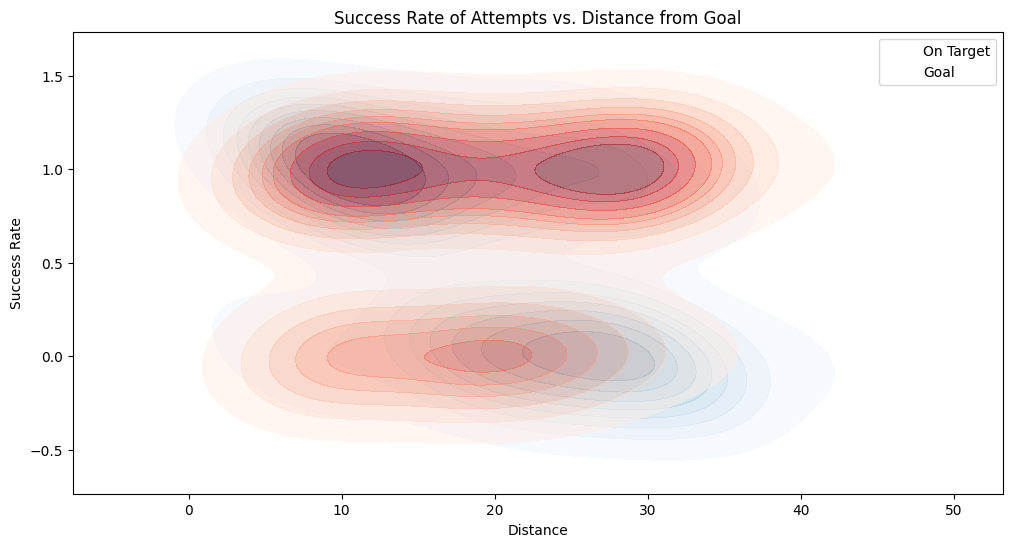

In [20]:
attempts_df = get_attempts_df()

# Convert boolean columns to int (1 for True, 0 for False)
attempts_df['onTarget'] = attempts_df['onTarget'].astype(int)
attempts_df['goal'] = attempts_df['goal'].astype(int)

# Create the Seaborn plot
plt.figure(figsize=(12, 6))

# Plot KDE for On Target attempts
sns.kdeplot(
    data=attempts_df, x='distance', y='onTarget',
    common_norm=False, fill=True, alpha=0.5,
    label='On Target', cmap='Blues'
)

# Plot KDE for Goal attempts
sns.kdeplot(
    data=attempts_df, x='distance', y='goal',
    common_norm=False, fill=True, alpha=0.5,
    label='Goal', cmap='Reds'
)

# Set labels and title
plt.xlabel('Distance')
plt.ylabel('Success Rate')
plt.title('Success Rate of Attempts vs. Distance from Goal')
plt.legend()

# Show the plot
plt.show()

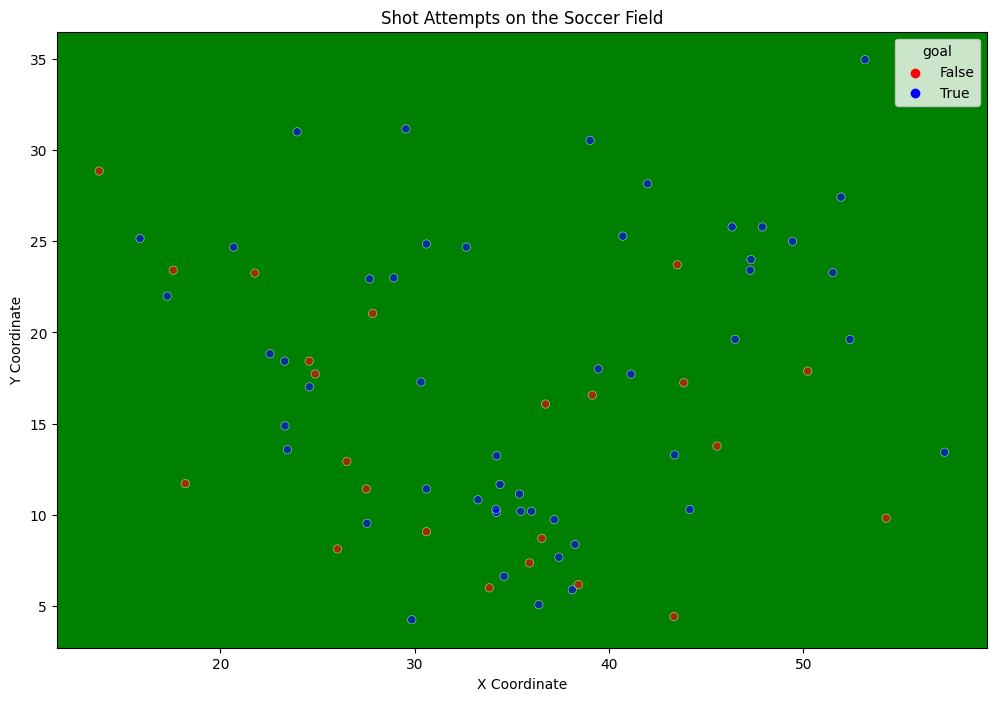

In [21]:
attempts_df = get_attempts_df()

# Create the soccer field figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_facecolor('green')

# Plot the shot attempts
sns.scatterplot(data=attempts_df, x='x', y='y', hue='goal', palette=['red', 'blue'], alpha=0.6)

# Set labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Shot Attempts on the Soccer Field')

# Show the plot
plt.show()

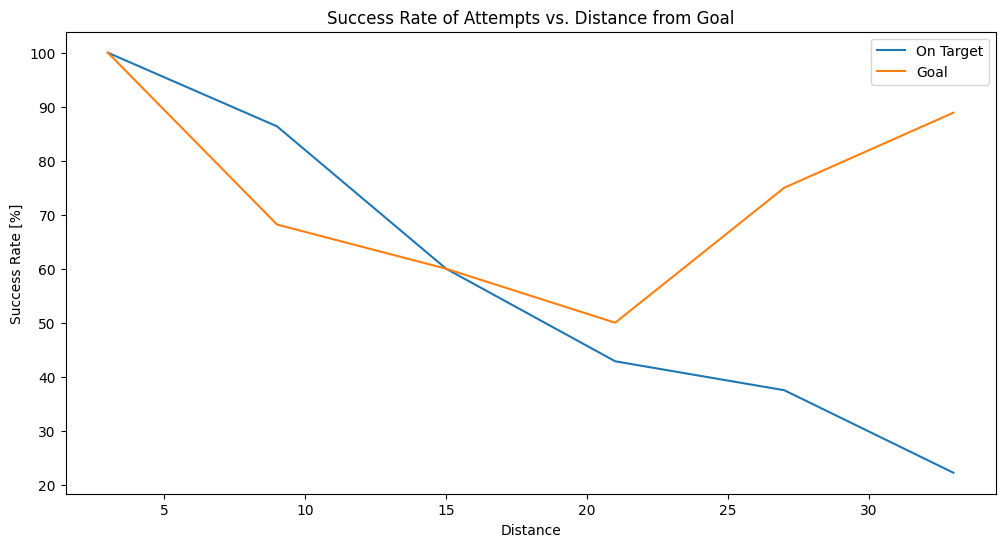

In [26]:
attempts_df = get_attempts_df()

# Convert boolean columns to int (1 for True, 0 for False)
attempts_df['onTarget'] = attempts_df['onTarget'].astype(int)
attempts_df['goal'] = attempts_df['goal'].astype(int)

# Define the distance bins
bin_edges = np.arange(0, attempts_df['distance'].max() + 1, 6)  # Change the bin width (5) as needed

# Bin the distances
attempts_df['distance_bin'] = pd.cut(attempts_df['distance'], bins=bin_edges)

# Calculate success rates for each bin
success_rate = attempts_df.groupby('distance_bin').agg(
    on_target_rate=pd.NamedAgg(column='onTarget', aggfunc='mean'),
    goal_rate=pd.NamedAgg(column='goal', aggfunc='mean')
).reset_index()

# Calculate the middle value of each bin
success_rate['bin_mid'] = success_rate['distance_bin'].apply(lambda x: x.mid)

success_rate['on_target_rate'] *= 100
success_rate['goal_rate'] *= 100

# Create the Seaborn plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=success_rate, x='bin_mid', y='on_target_rate', label='On Target')
sns.lineplot(data=success_rate, x='bin_mid', y='goal_rate', label='Goal')

# Set labels and title
plt.xlabel('Distance')
plt.ylabel('Success Rate [%]')
plt.title('Success Rate of Attempts vs. Distance from Goal')
plt.legend()

# Show the plot
plt.show()